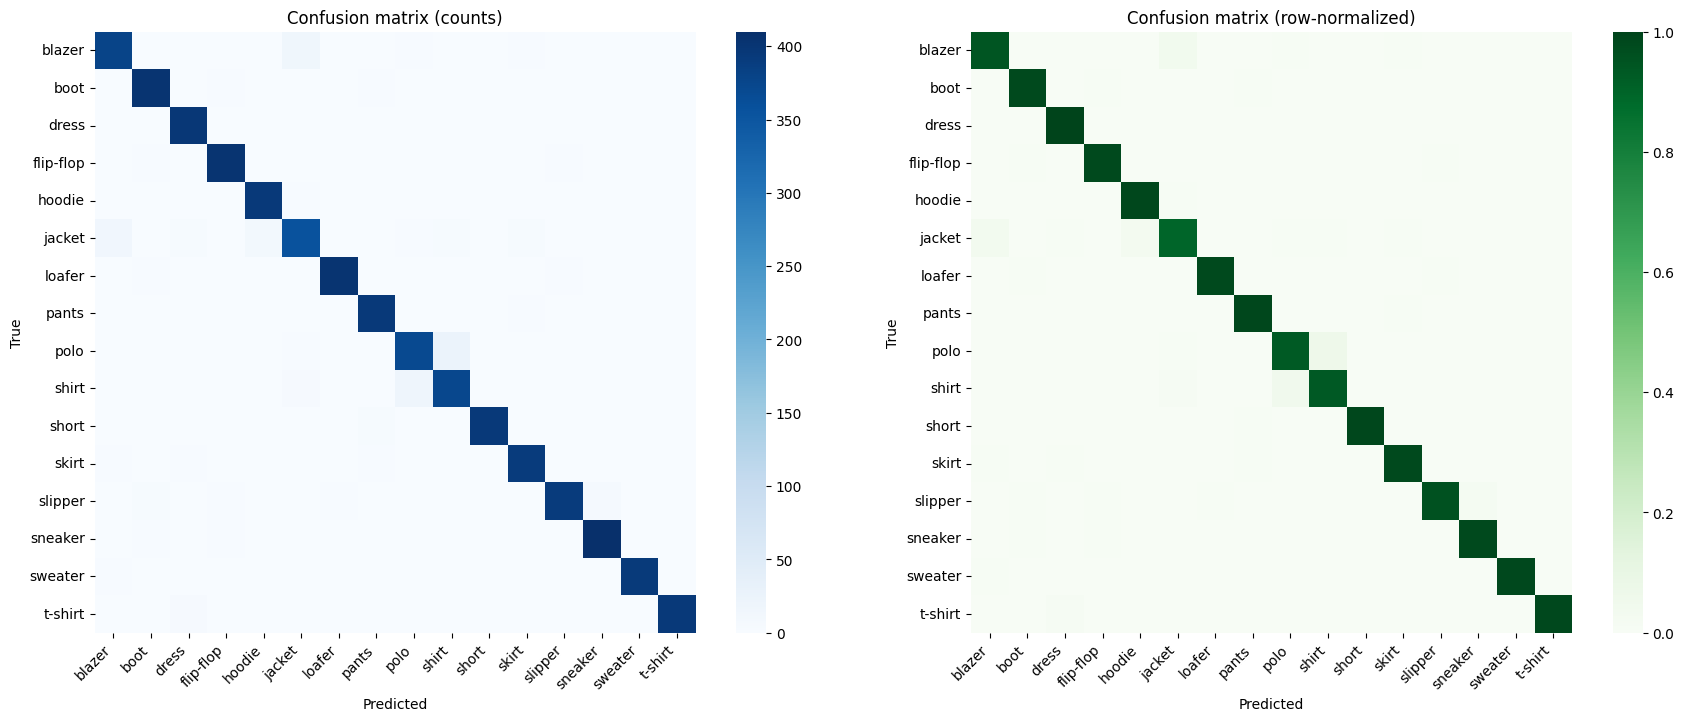

Saved arrays:
 - y_true shape: (6443,)
 - y_pred shape: (6443,)
 - conf_top1 shape: (6443,)


In [1]:
# Confusion matrix on val/ using best.pt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Deps
try:
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scikit-learn", "seaborn"])
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

try:
    from ultralytics import YOLO
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ultralytics"])
    from ultralytics import YOLO

# Resolve paths and model
PROJECT_ROOT = PROJECT_ROOT if 'PROJECT_ROOT' in globals() else (Path.cwd().resolve().parent if Path.cwd().name=="notebooks" else Path.cwd().resolve())
RUNS_DIR = PROJECT_ROOT / "runs-cls"
NAME = "yolov8n-cls-fashion"
VAL_DIR = (PROJECT_ROOT / "data" / "dataset-fashion-modisch" / "val")
pt_path = RUNS_DIR / NAME / "weights" / "best.pt"
if not pt_path.exists():
    cands = list(RUNS_DIR.rglob("best.pt"))
    assert cands, "best.pt not found under runs-cls"
    pt_path = cands[0]

model = YOLO(str(pt_path))
names_map = model.names  # dict[int] -> str
model_classes = [names_map[i] for i in sorted(names_map.keys())]
class_to_idx = {n:i for i,n in enumerate(model_classes)}

ALLOWED = {".jpg",".jpeg",".png",".bmp",".webp"}
def list_images(p: Path):
    return [f for f in p.iterdir() if f.is_file() and f.suffix.lower() in ALLOWED]

# Build dataset lists from val/ folder tree
val_classes = [d.name for d in VAL_DIR.iterdir() if d.is_dir()]
val_classes = sorted(val_classes)
imgs, y_true = [], []
for cls in val_classes:
    for p in list_images(VAL_DIR / cls):
        imgs.append(str(p))
        y_true.append(class_to_idx.get(cls, -1))
y_true = np.array(y_true, dtype=int)

# Predict stream
IMGSZ = IMGSZ if 'IMGSZ' in globals() else 224
results = model.predict(source=imgs, imgsz=IMGSZ, batch=64, verbose=False, stream=True)

y_pred = []
conf_top1 = []
for r in results:
    probs = getattr(r, "probs", None)
    if probs is None:
        raise RuntimeError("Result has no .probs — ensure this is a classification model.")
    # index
    idx = int(getattr(probs, "top1", None)) if hasattr(probs, "top1") else int(np.asarray(probs).ravel().argmax())
    # confidence
    arr = None
    if hasattr(probs, "data"):
        data = probs.data
        arr = data.detach().cpu().numpy().ravel() if hasattr(data, "detach") else np.asarray(data).ravel()
    if arr is None or arr.size == 0:
        arr = np.asarray(probs).ravel()
    y_pred.append(idx)
    conf_top1.append(float(arr[idx]))

y_pred = np.array(y_pred, dtype=int)
conf_top1 = np.array(conf_top1, dtype=float)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(model_classes))))
fig, ax = plt.subplots(1,2, figsize=(18,7))

sns.heatmap(cm, ax=ax[0], cmap="Blues", annot=False, cbar=True,
            xticklabels=model_classes, yticklabels=model_classes, fmt="d", square=True)
ax[0].set_title("Confusion matrix (counts)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")
plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right")

cm_norm = confusion_matrix(y_true, y_pred, labels=list(range(len(model_classes))), normalize="true")
sns.heatmap(cm_norm, ax=ax[1], cmap="Greens", annot=False, cbar=True,
            xticklabels=model_classes, yticklabels=model_classes, square=True, vmin=0, vmax=1)
ax[1].set_title("Confusion matrix (row-normalized)")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("Saved arrays:")
print(" - y_true shape:", y_true.shape)
print(" - y_pred shape:", y_pred.shape)
print(" - conf_top1 shape:", conf_top1.shape)

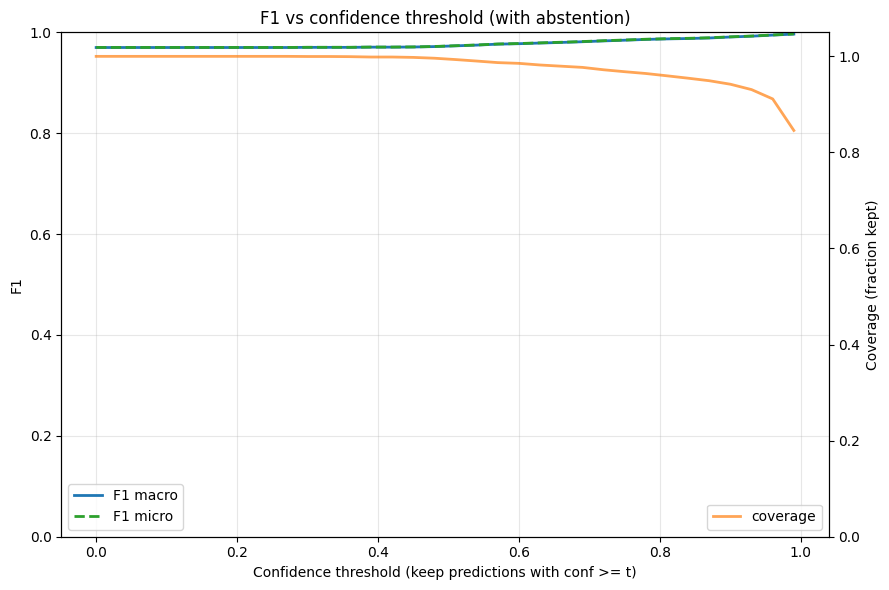

In [2]:
# F1 (macro/micro) vs confidence threshold with coverage
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

# Reuse y_true, y_pred, conf_top1 from previous cell
if 'y_true' not in globals() or 'y_pred' not in globals() or 'conf_top1' not in globals():
    raise RuntimeError("Run the confusion matrix cell first to populate y_true, y_pred, conf_top1.")

thresholds = np.linspace(0.0, 0.99, 34)  # up to <1.0
f1_macro, f1_micro, coverage = [], [], []

for t in thresholds:
    mask = conf_top1 >= t
    covered = int(mask.sum())
    coverage.append(covered / len(conf_top1))
    if covered == 0:
        f1_macro.append(np.nan)
        f1_micro.append(np.nan)
    else:
        yt = y_true[mask]
        yp = y_pred[mask]
        f1_macro.append(f1_score(yt, yp, average="macro"))
        f1_micro.append(f1_score(yt, yp, average="micro"))

fig, ax1 = plt.subplots(figsize=(9,6))
ax1.plot(thresholds, f1_macro, label="F1 macro", color="tab:blue", lw=2)
ax1.plot(thresholds, f1_micro, label="F1 micro", color="tab:green", lw=2, ls="--")
ax1.set_xlabel("Confidence threshold (keep predictions with conf >= t)")
ax1.set_ylabel("F1")
ax1.set_ylim(0, 1.0)
ax1.grid(True, alpha=0.3)
ax1.legend(loc="lower left")

ax2 = ax1.twinx()
ax2.plot(thresholds, coverage, label="coverage", color="tab:orange", lw=2, alpha=0.7)
ax2.set_ylabel("Coverage (fraction kept)")
ax2.set_ylim(0, 1.05)
ax2.legend(loc="lower right")
plt.title("F1 vs confidence threshold (with abstention)")

plt.tight_layout()
plt.show()

Loaded: /Users/macm4/repositories/Machine Learning Model/modisch-model-cls/runs-cls/yolov8n-cls-fashion/results.csv
Columns: ['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


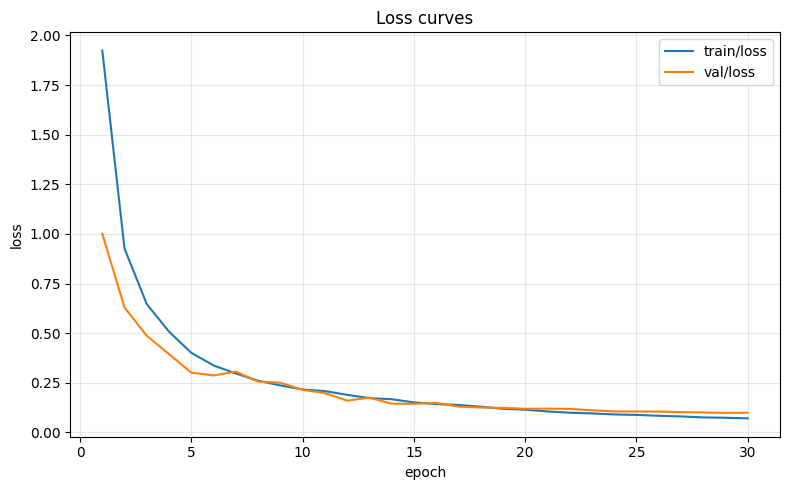

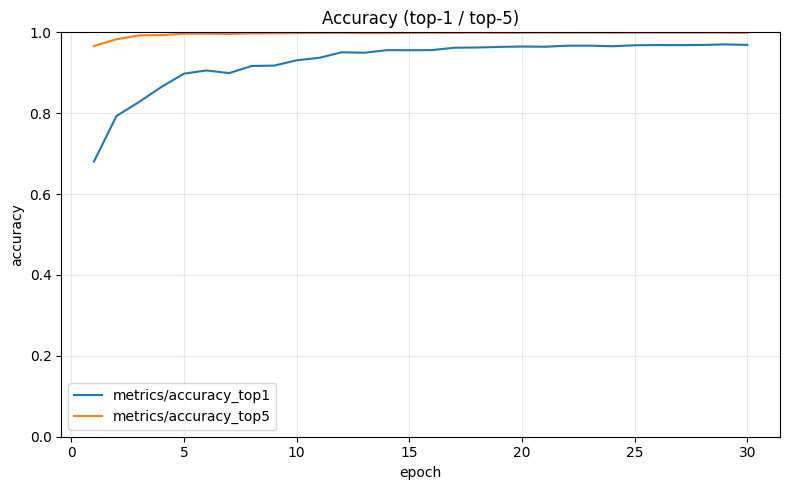

In [3]:
# Plot training curves from results.csv
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = PROJECT_ROOT if 'PROJECT_ROOT' in globals() else (Path.cwd().resolve().parent if Path.cwd().name=="notebooks" else Path.cwd().resolve())
RUNS_DIR = PROJECT_ROOT / "runs-cls"
NAME = "yolov8n-cls-fashion"

csv_path = RUNS_DIR / NAME / "results.csv"
if not csv_path.exists():
    cands = sorted((RUNS_DIR).rglob("results.csv"))
    assert cands, "results.csv not found under runs-cls"
    csv_path = cands[-1]

df = pd.read_csv(csv_path)
print("Loaded:", csv_path)
print("Columns:", list(df.columns))

# Try to locate typical columns
epoch_col = next((c for c in df.columns if c.lower().startswith("epoch")), None)
top1_col = next((c for c in df.columns if "top1" in c.lower()), None)
top5_col = next((c for c in df.columns if "top5" in c.lower()), None)
loss_cols = [c for c in df.columns if "loss" in c.lower()]

# Plot losses
if loss_cols:
    plt.figure(figsize=(8,5))
    for c in loss_cols:
        plt.plot(df[epoch_col] if epoch_col else range(len(df)), df[c], label=c)
    plt.title("Loss curves")
    plt.xlabel("epoch" if epoch_col else "row")
    plt.ylabel("loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot accuracies
if top1_col or top5_col:
    plt.figure(figsize=(8,5))
    if top1_col:
        plt.plot(df[epoch_col] if epoch_col else range(len(df)), df[top1_col], label=top1_col)
    if top5_col:
        plt.plot(df[epoch_col] if epoch_col else range(len(df)), df[top5_col], label=top5_col)
    plt.title("Accuracy (top-1 / top-5)")
    plt.xlabel("epoch" if epoch_col else "row")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()